# Colab de Testeo

Ya con los modelos entrenados en sus respectivos colab (consultar otros colabs) y obteniendo archivos con sus pesos para cada uno vamos a proceder a testear los resultados.
Primero testearemos con los set de validación y test originales y posteriormente crearemos variaciones de estos set de test para analizar dos cosas:
1. La capacidad de generalización de cada modelo
2. En qué se fija cada modelo para decidir a que caracter corresponde la imagen

## Librerías

In [ ]:
import os
import shutil
import subprocess
import numpy as np
import pandas as pd
import scipy.io
import random
from PIL import Image
from copy import copy, deepcopy
from IPython.display import display
from tabulate import tabulate
import cv2

import matplotlib.pyplot as plt

from os import listdir
from os.path import join
from tqdm.notebook import tqdm
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split

import torchvision.models as models
import torchvision.transforms as transforms

from torchsummary import summary
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights, ResNet50_Weights

In [ ]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda:0


## Load Dataset

In [ ]:
repo_url = 'https://github.com/brendenlake/omniglot.git'
subprocess.call(['git', 'clone', repo_url])

0

In [ ]:
!unzip -qq './omniglot/python/images_background.zip'
!unzip -qq './omniglot/python/strokes_background.zip'

## Orden de las imágenes

Realizamos el mismo orden que en los colabs de entrenamiento.
En la carpeta images_background, hay 30 alfabetos diferentes. Cada alfabeto contiene una cantidad variada de caracteres, entre 20-50 aprox. Cada uno de los caracteres cuenta es de la forma XXXX_YY.png, donde XXXX corresponde al identificador del caracter, el cual es único entre todos los caracteres de todos los alfabetos. YY corresponde al número de muestra de un caracter en específico, el cual va siempre desde 01 hasta 20 (20 muestras por caracter).

Ahora bien, el problema está en que los XXXX no vienen ordenados secuencialmente en cada uno de los alfabetos. Por lo tanto, para hacer el preprocesamiento, hará un diccionario que mapeará cada uno de los id a un valor ordenado, para que la posterior clasificación sea más rápida.

In [ ]:
img_dir = 'images_background'
stroke_dir = 'strokes_background'
nreps = 20 # number of renditions for each character
# nalpha = 5 # number of alphabets to show

alphabet_names = sorted([a for a in os.listdir(img_dir) if a[0] != '.']) # get folder names
length_alphabet_names = len(alphabet_names)
character_lengths = [len(os.listdir(os.path.join(img_dir, alph_name))) for alph_name in alphabet_names]

# alphabet_names = random.sample(alphabet_names,nalpha) # choose random alphabets
# print(len(alphabet_names))

N = sum([len(os.listdir(os.path.join(img_dir, alph_name, char)))
            for alph_name in alphabet_names
            for char in os.listdir(os.path.join(img_dir, alph_name))
      ])


y = np.zeros((N), 'int') # ground truth
current_character_folder = 0 # carpeta de un caracter visitado

df_alphabet_names = []
df_character_names = []
df_character_idx = []
df_paths = []
df_y = []

for i in range(len(alphabet_names)):
  alphabet_name = alphabet_names[i]
  character_length = character_lengths[i]
  character_folders = sorted(os.listdir(os.path.join(img_dir, alphabet_name)))

  for j in range(character_length):
    character_folder = character_folders[j]
    characters = sorted(os.listdir(os.path.join(img_dir, alphabet_name, character_folder)))
    # print(character_folder)

    for k in range(nreps):
      y[(current_character_folder * nreps) + k] = current_character_folder

      # Se añade al Df
      df_alphabet_names.extend([alphabet_name])
      df_character_names.extend([character_folder])
      df_character_idx.extend([k])
      df_paths.extend([os.path.join(img_dir, alphabet_name, character_folder, characters[k])])
      df_y.extend([current_character_folder])

    current_character_folder += 1


df = pd.DataFrame({
    'Alphabet': df_alphabet_names,
    'Character': df_character_names,
    'Sample': df_character_idx,
    'Path': df_paths,
    'y': df_y
})

## Ejemplo de una imagen original

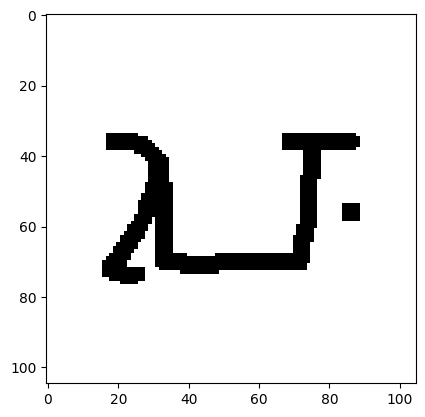

In [ ]:
path = df.iloc[0]['Path']
img = Image.open(path)
# print('Shape:', img.shape)
plt.imshow(img, cmap='gray')
plt.show()

In [ ]:
print(img)

<PIL.PngImagePlugin.PngImageFile image mode=1 size=105x105 at 0x7FAFC1C70880>


## Obtención Validación y Test original

El objetivo de la ResNet es justamente clasificar cada uno de los caracteres. En total, tenemos 964 caracteres distintos (labels enumerados del 0 al 963), provenientes de 30 alfabetos, y cada caracter posee 20 muestras. Por ende, tenemos 19280 imagenes distintas.

Dado que cada caracter posee 20 muestras, se utilizará una proporción 70% train, 20% validation y 10% test. Vale decir: 14 imágenes de train, 4 de validation, y 2 de test por cada caracter.

En total debería dar:
* 13.496 imágenes de Train
* 3.856 imágenes de Validation
* 1.928 imágenes de Test

In [ ]:
# Separacion de df basados en el numero de fila
# df_train = df.groupby('y').head(14)
df_val = df.groupby('y').apply(lambda x: x.iloc[14:18])
df_test = df.groupby('y').apply(lambda x: x.iloc[18:20])

# Reseteamos los indices de los df
# df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)


In [ ]:
# print('Length df_train:', len(df_train))
print('Length df_val:', len(df_val))
print('Length df_test:', len(df_test))

Length df_val: 3856
Length df_test: 1928


In [ ]:
class Character(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.transform = transform
        self.images = images     # Vincula el indice con un nombre de archivo
        self.labels = labels     # Vincula el indice con una clase

    def get_image(self, path):
        # img = plt.imread(path)
        img = Image.open(path)
        return img

    def __getitem__(self, idx):
        path_name = self.images[idx]
        label = self.labels[idx]
        img = self.get_image(path_name)

        if self.transform is not None:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.images)

In [ ]:
# Set up data transformations
transform = Compose([
    lambda x: x.convert('RGB'),
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
# train_dataset = Character(images=df_train['Path'], labels=df_train['y'], transform=transform)
val_dataset = Character(images=df_val['Path'], labels=df_val['y'], transform=transform)
test_dataset = Character(images=df_test['Path'], labels=df_test['y'], transform=transform)

In [ ]:
batch_size = 64
shuffle = True
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)

## Transfer learning functions

### Padding images

La primera variacion de los sets es un padding. Realizaremos un padding a todas las imagenes, los caracteres serán desplazados a la esquina superior izquierda, esto nos servirá para testear cuánto influye la posición del caracter en la determinación de su clase. A continuación un ejemplo de como se verán las nuevas imágenes:

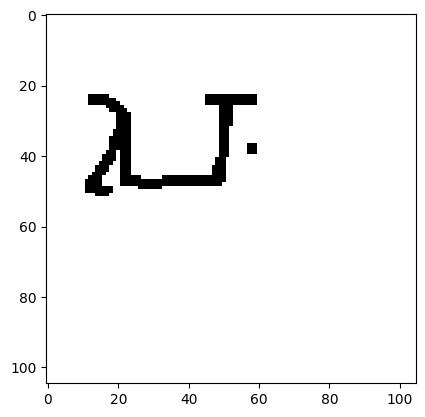

In [ ]:
def get_image(path):
    # img = plt.imread(path)
    img = Image.open(path)
    width, height = img.size

    desired_width = width + 50  # Adjust the padding width as needed
    desired_height = height + 50
    padded_img = Image.new('1', (desired_width, desired_height), 1)
    padded_img.paste(img, (0, 0))
    res = padded_img.resize((105, 105))
    return res
path = df.iloc[0]['Path']
img_testeando = get_image(path)
# print('Shape:', img.shape)
plt.imshow(img_testeando, cmap='gray')
plt.show()

#### Definición de la clase y construcción de loaders

In [ ]:
class PadCharacter(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.transform = transform
        self.images = images     # Vincula el indice con un nombre de archivo
        self.labels = labels     # Vincula el indice con una clase

    def get_image(self, path):
      # img = plt.imread(path)
      img = Image.open(path)
      width, height = img.size

      desired_width = width + 50  # Adjust the padding width as needed
      desired_height = height + 50
      padded_img = Image.new('1', (desired_width, desired_height), 1)
      padded_img.paste(img, (0, 0))
      res = padded_img.resize((105, 105))
      return res

    def __getitem__(self, idx):
        path_name = self.images[idx]
        label = self.labels[idx]
        img = self.get_image(path_name)

        if self.transform is not None:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.images)

In [ ]:
# Set up data transformations
transform = Compose([
    lambda x: x.convert('RGB'),
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# train_pad_set = PadCharacter(images=df_train['Path'], labels=df_train['y'], transform=transform)
val_pad_set = PadCharacter(images=df_val['Path'], labels=df_val['y'], transform=transform)
test_pad_set = PadCharacter(images=df_test['Path'], labels=df_test['y'], transform=transform)

In [ ]:
# Set up the train loader
batch_size = 64
shuffle = True
# train_pad_loader = DataLoader(train_pad_set, batch_size=batch_size, shuffle=shuffle)
val_pad_loader = DataLoader(val_pad_set, batch_size=batch_size, shuffle=shuffle)
test_pad_loader = DataLoader(test_pad_set, batch_size=batch_size, shuffle=shuffle)

### Change background

La segunda variación es un cambio en el color del background. Realizaremos una inversión en los colores. Actualmente las imágenes poseen fondo blanco y el caracter en negro. Probaremos fondo negro y caracter blanco. Esto nos servirá para testear cuánto influye el color del caracter y su fondo en la determinación de su clase. A continuación un ejemplo de como se verán las nuevas imágenes:

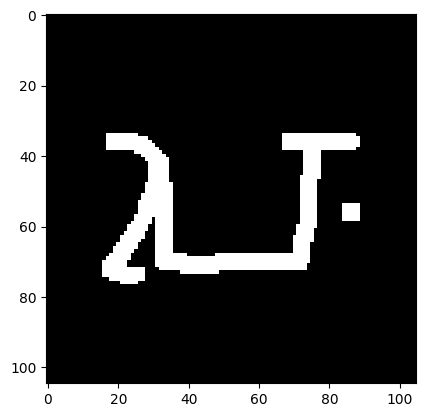

In [ ]:
def get_image(path):
    # img = plt.imread(path)
    img = Image.open(path)
    inverted_image = img.point(lambda x: 1 - x)
    return inverted_image
path = df.iloc[0]['Path']
img_testeando = get_image(path)
# print('Shape:', img.shape)
plt.imshow(img_testeando, cmap='gray')
plt.show()

#### Definición de la clase y construcción de loaders

In [ ]:
class BackCharacter(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.transform = transform
        self.images = images     # Vincula el indice con un nombre de archivo
        self.labels = labels     # Vincula el indice con una clase

    def get_image(self, path):
      # img = plt.imread(path)
      img = Image.open(path)
      inverted_image = img.point(lambda x: 1 - x)
      return inverted_image

    def __getitem__(self, idx):
        path_name = self.images[idx]
        label = self.labels[idx]
        img = self.get_image(path_name)

        if self.transform is not None:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.images)

In [ ]:
# Set up data transformations
transform = Compose([
    lambda x: x.convert('RGB'),
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# train_back_set = BackCharacter(images=df_train['Path'], labels=df_train['y'], transform=transform)
val_back_set = BackCharacter(images=df_val['Path'], labels=df_val['y'], transform=transform)
test_back_set = BackCharacter(images=df_test['Path'], labels=df_test['y'], transform=transform)

In [ ]:
# Set up the train loader
batch_size = 64
shuffle = True
# train_back_loader = DataLoader(train_back_set, batch_size=batch_size, shuffle=shuffle)
val_back_loader = DataLoader(val_back_set, batch_size=batch_size, shuffle=shuffle)
test_back_loader = DataLoader(test_back_set, batch_size=batch_size, shuffle=shuffle)

### Add strokes to images

La ultima variación de los sets es añadir los strokes. Realizaremos funciones para que todas las imagenes se visualicen con sus respectivos strokes de colores, esto nos servirá para testear cuánto influye el color del caracter, manteniendo el fondo, en la determinación de su clase. A continuación un ejemplo de como se verán las nuevas imágenes:

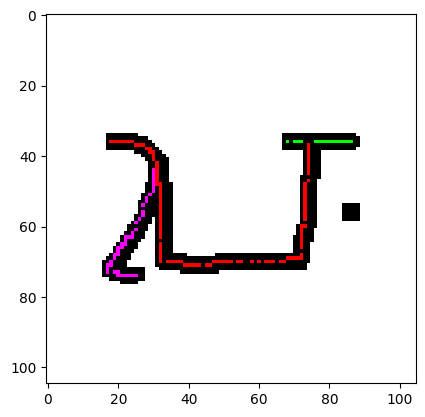

In [ ]:
# Load stroke data for a character from text file
def load_motor(fn):
	motor = []
	with open(fn,'r') as fid:
		lines = fid.readlines()
	lines = [l.strip() for l in lines]
	for myline in lines:
		if myline =='START': # beginning of character
			stk = []
		elif myline =='BREAK': # break between strokes
			stk = np.array(stk)
			motor.append(stk) # add to list of strokes
			stk = []
		else:
			arr = np.fromstring(myline,dtype=float,sep=',')
			stk.append(arr)
	return motor

# Color map for the stroke of index k
def get_color(k):
    scol = [(255,0,0),(0,255,0),(0,0,255),(255,0,255),(0,255,255), (255,255,0)]
    ncol = len(scol)
    if k < ncol:
       out = scol[k]
    else:
       out = scol[-1]
    return out

# Map from motor space to image space (or vice versa)
def space_motor_to_img(pt):
	pt[:,1] = -pt[:,1]
	return pt
def space_img_to_motor(pt):
	pt[:,1] = -pt[:,1]
	return

def draw_image(img, motor):
  drawing = [d[:,0:2] for d in motor] # strip off the timing data (third column)
  drawing = [space_motor_to_img(d) for d in drawing] # convert to image space

  for sid in range(len(drawing)): # for each stroke
    stk = drawing[sid]
    color = get_color(sid)
    if stk.shape[0] > 1:
      for i in stk:
        if i[0] >104 or i[1]>104:
          continue
        img[int(i[1]), int(i[0]), :] = color
  return img

def get_image(path):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    sep_path = path.split('/')
    assem_path = "strokes_background/" + '/'.join(sep_path[1:])
    path_to_stroke = assem_path[:-3] + 'txt'
    motor = load_motor(path_to_stroke)
    pixels = draw_image(img, motor)
    return pixels

path = df.iloc[0]['Path']
img_testeando = get_image(path)

plt.imshow(img_testeando)
plt.show()

#### Definición de la clase y construcción de loaders

In [ ]:
class StrokeCharacter(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.transform = transform
        self.images = images     # Vincula el indice con un nombre de archivo
        self.labels = labels     # Vincula el indice con una clase

    def get_image(self, path):
      img = cv2.imread(path, cv2.IMREAD_COLOR)
      sep_path = path.split('/')
      assem_path = "strokes_background/" + '/'.join(sep_path[1:])
      path_to_stroke = assem_path[:-3] + 'txt'
      motor = load_motor(path_to_stroke)
      pixels = draw_image(img, motor)
      image = Image.fromarray(pixels)
      return image

    def __getitem__(self, idx):
        path_name = self.images[idx]
        label = self.labels[idx]
        img = self.get_image(path_name)

        if self.transform is not None:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.images)

In [ ]:
# Set up data transformations
transform = Compose([
    lambda x: x.convert('RGB'),
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# train_stroke_set = StrokeCharacter(images=df_train['Path'], labels=df_train['y'], transform=transform)
val_stroke_set = StrokeCharacter(images=df_val['Path'], labels=df_val['y'], transform=transform)
test_stroke_set = StrokeCharacter(images=df_test['Path'], labels=df_test['y'], transform=transform)

In [ ]:
# Set up the train loader
batch_size = 64
shuffle = True
# train_stroke_loader = DataLoader(train_stroke_set, batch_size=batch_size, shuffle=shuffle)
val_stroke_loader = DataLoader(val_stroke_set, batch_size=batch_size, shuffle=shuffle)
test_stroke_loader = DataLoader(test_stroke_set, batch_size=batch_size, shuffle=shuffle)

## Test model function

In [ ]:
# Función para correr inferencia usando un modelo y un
# DataLoader con nuestros datos del set de test.
def test_model(model, test_dl):
    total_correctas = 0.0
    total_muestras = 0.0

    for x, target in test_dl:          # Iteramos sobre nuestros datos
        # Inicio de la iteración
        model.eval()                        # Dejamos el modelo en modo evaluación
        with torch.no_grad():               # No se calculará información de gradientes
                                            # en el código de más abajo.
            x = x.to(device)
            target = target.to(device)         # Enviamos nuestros datos a GPU
            output = model(x)               # Hacemos el forward de nuestros datos

            preds = output.argmax(dim=1)             # El máximo valor es nuestra predicción
            correctas = (preds == target).sum()      # Acumulamos las correctas durante la época
            total_correctas += correctas
            total_muestras += target.shape[0]        # Sumamos el tamaño del batch

            accuracy = total_correctas/total_muestras # Acc = correctas/total

    return accuracy

## Cargamos modelo guardado

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


Navegamos hasta la carpeta compartida

In [ ]:
# %cd './drive/Shareddrives/IIC3697-Proyecto/'

/content/drive/Shareddrives/IIC3697-Proyecto


In [ ]:
# Obtener la lista de archivos y carpetas dentro de la carpeta
model_paths = {}
contenido = os.listdir('./')
for c in contenido:
  if os.path.isdir(c) and not (c in ['VitGAN', 'omniglot', 'images_background', 'strokes_background', '__MACOSX']):
    new_path = './' + c + '/weights'
    sub_contenido = os.listdir(new_path)
    if len(sub_contenido) > 0:
      model_paths[new_path] = sub_contenido

print(model_paths)

{'./ResNeXt/weights': ['ResNeXt_009_1e-3_Adam.pt', 'ResNeXt_009_1e-2_Adam.pt', 'ResNeXt_009_5e-3_Adam.pt', 'ResNeXt_009_6e-3_Adam.pt'], './RegNet/weights': ['RegNet_009_1e-1_SGD.pt', 'RegNet_007_1e-2_SGD.pt'], './ResNet/weights': ['resnet50_049.pt', 'Resnet_049_1e-0_SGD.pt', 'Resnet_049_1e-1_SGD.pt', 'Resnet_049_1e-2_SGD.pt']}


In [ ]:
total_accs = [['model',
               'val',
               'test',
               'val pad',
               'test pad',
               'val back',
               'test back',
               'val stroke',
               'test stroke']]

loaders = [val_loader,
           test_loader,
           val_pad_loader,
           test_pad_loader,
           val_back_loader,
           test_back_loader,
           val_stroke_loader,
           test_stroke_loader]

for dir in model_paths.keys():
  print("Instanciando Modelo:\t", dir)
  for m in model_paths[dir]:
    print("Probando pesos:\t", m)
    accs = [m]
    full_path = dir + "/" + m
    model = torch.load(full_path)
    for loader in loaders:
      print("Probando loader:\t", loader)
      acc = test_model(model, loader).item()
      print(acc)
      accs.append(acc)
    total_accs.append(accs)

Instanciando Modelo:	 ./ResNeXt/weights
Probando pesos:	 ResNeXt_009_1e-3_Adam.pt
Probando loader:	 <torch.utils.data.dataloader.DataLoader object at 0x7fafbaec35b0>
0.22873444855213165
Probando loader:	 <torch.utils.data.dataloader.DataLoader object at 0x7fafbaec28f0>
0.24636930227279663
Probando loader:	 <torch.utils.data.dataloader.DataLoader object at 0x7fafb8d1d660>
0.04590249061584473
Probando loader:	 <torch.utils.data.dataloader.DataLoader object at 0x7fafb8d1d720>
0.044605810195207596
Probando loader:	 <torch.utils.data.dataloader.DataLoader object at 0x7fafbaf46560>
0.0010373444529250264
Probando loader:	 <torch.utils.data.dataloader.DataLoader object at 0x7fafbaf449d0>
0.0010373444529250264
Probando loader:	 <torch.utils.data.dataloader.DataLoader object at 0x7fb0a6e4d660>
0.0036307056434452534
Probando loader:	 <torch.utils.data.dataloader.DataLoader object at 0x7fafc390a140>
0.007780083455145359
Probando pesos:	 ResNeXt_009_1e-2_Adam.pt
Probando loader:	 <torch.utils.data.

#### Tabla con todos los resultados

In [ ]:
table = tabulate(total_accs, headers='firstrow', tablefmt='fancy_grid')
print(table)

╒═══════════════════════════════╤══════════╤══════════╤═══════════╤════════════╤═════════════╤═════════════╤══════════════╤═══════════════╕
│ model                         │      val │     test │   val pad │   test pad │    val back │   test back │   val stroke │   test stroke │
╞═══════════════════════════════╪══════════╪══════════╪═══════════╪════════════╪═════════════╪═════════════╪══════════════╪═══════════════╡
│ vgg16_099_1e-4_Adam.pt        │ 0.489367 │ 0.522303 │ 0.103216  │  0.104253  │ 0.0931017   │ 0.0975104   │   0.141857   │    0.168568   │
├───────────────────────────────┼──────────┼──────────┼───────────┼────────────┼─────────────┼─────────────┼──────────────┼───────────────┤
│ vgg16_080_5e-3_SGD.pt         │ 0.393932 │ 0.426349 │ 0.094139  │  0.0850622 │ 0.0736515   │ 0.0819502   │   0.116442   │    0.155083   │
├───────────────────────────────┼──────────┼──────────┼───────────┼────────────┼─────────────┼─────────────┼──────────────┼───────────────┤
│ vgg16_030_5e-2_SGD

#### Grafico de los mejores modelos

In [ ]:
def filter_rows(data, indices):
    filtered_data = [data[i] for i in indices if 0 <= i < len(data)]
    return filtered_data

In [ ]:
# escogemos mejores resultados de cada modelo
total_accs = filter_rows(total_accs, [0, 1, 7, 10, 13, 16])

In [ ]:
total_accs =[['model','val','test','val pad','test pad','val back','test back','val stroke','test stroke'],
            ["vgg16_099_1e-4_Adam.pt", 0.489367, 0.522303, 0.103216, 0.104253, 0.0931017, 0.0975104, 0.141857, 0.168568],
            ["EfficientNet_050_1e-4_Adam.pt", 0.39471, 0.43361, 0.0713174, 0.0741701, 0.00337137, 0.00414938, 0.0064834, 0.0145228],
            ["ResNeXt_009_5e-3_Adam.pt", 0.242739, 0.264004, 0.0490145, 0.0544606, 0.000259336, 0.000518672, 0.00363071, 0.0108921],
            ["RegNet_007_1e-2_SGD.pt", 0.210062, 0.211618, 0.0845436, 0.0923237, 0.0108921, 0.0134855, 0.0518672, 0.0534232],
            ["Resnet_049_1e-1_SGD.pt", 0.182054, 0.205913, 0.0510892, 0.0529046, 0.00103734, 0.00103734,  0.00259336, 0.00985477],]

In [ ]:
def create_bar_graph(data):
    experiment_types = data[0][1:] # Get experiment types from the first row
    num_experiments = len(experiment_types)
    num_models = len(data) - 1

    # Generate x-axis labels
    model_names = [row[0] for row in data[1:]]

    # Prepare data for plotting
    model_indices = np.arange(num_models)
    bar_width = 0.6 / num_experiments


    # Create the bar graph
    fig, ax = plt.subplots()
    for i in range(num_experiments):
        experiment_results = [row[i+1] for row in data[1:]]
        bars = ax.bar(model_indices + i * (bar_width), experiment_results, bar_width, label=experiment_types[i])
        for bar in bars:
          height = round(bar.get_height(), 2)
          ax.annotate(f'{height}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                      textcoords='offset points', ha='center', va='bottom', fontsize=7)

    # Add labels, title, and legend
    ax.set_xlabel('Models')
    ax.set_ylabel('Accuracy')
    ax.set_title('Bar Graph')
    ax.set_xticks(model_indices + (num_experiments - 1) * (bar_width))
    ax.set_xticklabels(model_names, rotation=45)
    ax.legend()

    plt.show()

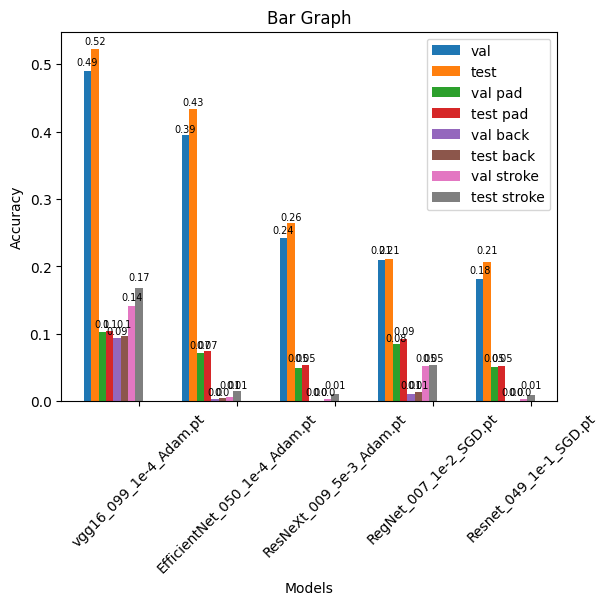

In [ ]:
create_bar_graph(total_accs)

In [ ]:
def filter_cols(data, indices):
    filtered_data = [[row[i] for i in indices] for row in data]
    return filtered_data

#### Grafico mejores modelos solo para validacion

Asumiendo que ya se filtraron las filas

In [ ]:
# escogemos mejores resultados de cada modelo
total_accs_val = [[row[i] for i in [0,1,3,5,7]] for row in total_accs]

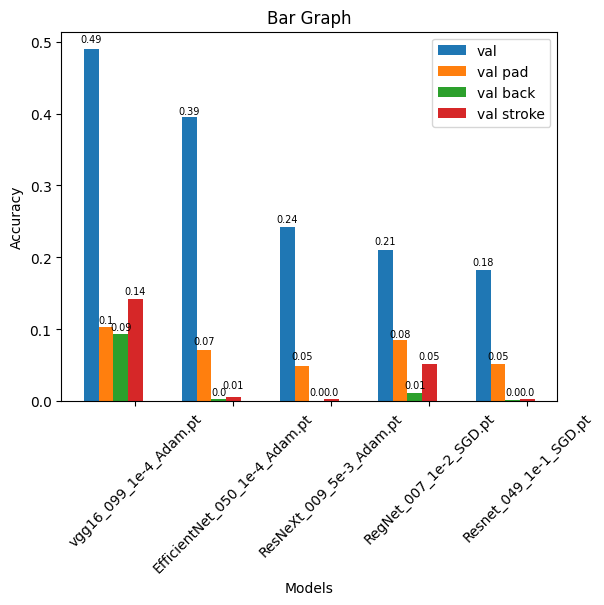

In [ ]:
create_bar_graph(total_accs_val)

#### Grafico mejores modelos solo para test

In [ ]:
# escogemos mejores resultados de cada modelo
total_accs_test = [[row[i] for i in [0,2,4,6,8]] for row in total_accs]

In [ ]:
total_accs_test

[['model', 'test', 'test pad', 'test back', 'test stroke'],
 ['vgg16_099_1e-4_Adam.pt', 0.522303, 0.104253, 0.0975104, 0.168568],
 ['EfficientNet_050_1e-4_Adam.pt', 0.43361, 0.0741701, 0.00414938, 0.0145228],
 ['ResNeXt_009_5e-3_Adam.pt', 0.264004, 0.0544606, 0.000518672, 0.0108921],
 ['RegNet_007_1e-2_SGD.pt', 0.211618, 0.0923237, 0.0134855, 0.0534232],
 ['Resnet_049_1e-1_SGD.pt', 0.205913, 0.0529046, 0.00103734, 0.00985477]]

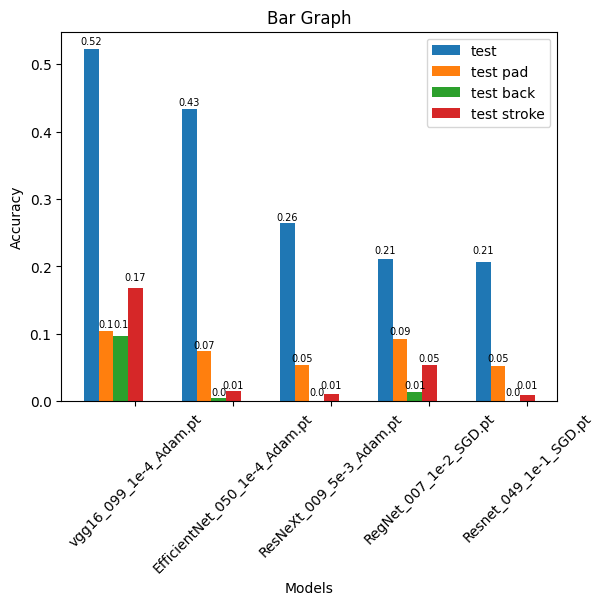

In [ ]:
create_bar_graph(total_accs_test)